In [0]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

train = pd.read_csv("/content/drive/My Drive/会津大学院/遊び/Youtube/train_data.csv")
test = pd.read_csv("/content/drive/My Drive/会津大学院/遊び/Youtube/test_data.csv")

train_x = train.drop(['y'],axis=1)
train_y = np.log1p(train['y']) 

test_x = test.copy()

train_x = train_x.drop(['id','video_id','title','thumbnail_link','description'], axis=1)
test_x = test_x.drop(['id','video_id','title','thumbnail_link','description'], axis=1)


In [0]:
train_x

,publishedAt,channelId,channelTitle,categoryId,collection_date,tags,likes,dislikes,comment_count,comments_disabled,ratings_disabled
0,2011-01-09T05:50:33.000Z,UCQaNYC3dNvH8FqrEyK7hTJw,DjangoShiny,20,20.01.02,Inazuma|Eleven|Super|Once|bgm|ost|イナズマイレブン|Kyo...,114,0,7,False,False
1,2012-07-23T03:00:09.000Z,UChMWDi-HBm5aS3jyRSaAWUA,ねごと Official Channel,10,20.08.02,ねごと|ネゴト|メルシールー|Re:myend|リマインド|Lightdentity|ライデ...,2885,50,111,False,False
2,2007-07-26T13:54:09.000Z,UCBdcyoZSt5HBLd_n6we-xIg,siropai,24,20.14.01,VF3|VF4|VF5|ちび太|闇よだれ|chibita|virtuafighter|seg...,133,17,14,False,False
3,2005-05-15T02:38:43.000Z,UC7K5am1UAQEsCRhzXpi9i1g,Jones4Carrie,22,19.22.12,frosty,287,51,173,False,False
4,2007-09-09T09:52:47.000Z,UCTW1um4R-QWa8iIfITGvlZQ,Tatsuya Maruyama,10,20.08.01,ギター|guitar|南澤大介|トップオブザワールド|トップ|オブ|ワールド|カーペンターズ...,178,6,17,False,False
...,...,...,...,...,...,...,...,...,...,...,...
19715,2015-01-12T09:02:32.000Z,UCOIib687CvPbspbVsXimX6Q,papadesuyo777,26,20.08.02,料理|レシピ|クッキング|クッキングSパパ|cook|cooking|resipe|how-...,546,7,51,False,False
19716,2016-05-20T09:29:55.000Z,UCqs6vaEyNntdwKmCiwfZrLA,エグスプロージョン チャンネル,24,20.09.02,[none],37141,1768,3435,False,False
19717,2009-08-27T20:15:52.000Z,UC_976xMxPgzIa290Hqtk-9g,Walt Disney Animation Studios,1,20.21.01,Walt Disney|Disney|Disney Princess|Sleeping Be...,1725,326,3,False,False
19718,2010-02-13T05:12:29.000Z,UCc8bGr2qHom-JrkEkHrTcSw,アニマート動物病院,15,20.22.01,アニマート動物病院|奈良県|桜井市|橿原市|白猫,1,0,0,False,False


tagsを分解して変数 スパース？
collection_date,publishedAtを年、月、日で分解
lightgbm学習率(デフォルト0.1)1に近いほど過学習しないのでイテレーションを増やせる
channelTitleから"Official"などの文字列を認識して変数を新たに作る？？

In [0]:
le_data = train_x.append(test_x)
for c in ['publishedAt','channelId','channelTitle','collection_date','tags','comments_disabled','ratings_disabled']:
  le = LabelEncoder()
  le.fit(le_data[c].fillna('NA'))
  train_x[c] = le.transform(train_x[c].fillna('NA'))
  test_x[c] = le.transform(test_x[c].fillna('NA'))

In [0]:
#rmse_scores = []
#pred_cv = np.zeros(len(test_x.index))
rmse_scores = []
preds = []
preds_test = []
va_idxes = []
pred_cv = np.zeros(len(test_x.index))


fold_num = 10
kf = KFold(n_splits=fold_num, shuffle=True, random_state=71)
for n_fold, (tr_idx, va_idx) in enumerate(kf.split(train_x)):
    tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
    tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
    lgb_train = lgb.Dataset(tr_x,tr_y)
    lgb_eval = lgb.Dataset(va_x,va_y)

    params = {
        'obejective':'rmse',
        'seed':71,
        'verbose':1,
        'metrics':'rmse',
        'max_depth' : 20,
        #'num_leaves' : 20 # 付け足した5/01
    }

    lgb_model = lgb.train(
        params,
        lgb_train,
        num_boost_round = 500,
        valid_names=['train','valid'],
        valid_sets=[lgb_train,lgb_eval],
        verbose_eval=100
                   )
    va_pred = lgb_model.predict(va_x)
    mse = mean_squared_error(va_y, va_pred)
    rmse = np.sqrt(mse)
    rmse_scores.append(rmse)

    # -- スタッキング試し--
    pred = lgb_model.predict(va_x)
    preds.append(pred)
    pred_test = lgb_model.predict(test_x)
    preds_test.append(pred_test)
    va_idxes.append(va_idx)
    # -- --
    
    submission = lgb_model.predict(test_x, num_iteration=lgb_model.best_iteration) 
    pred_cv += submission/fold_num
    print(n_fold+1,"回目のrmsle:",rmse)

print("rmsle平均",np.mean(rmse_scores))
# -- スタッキング試し --
va_idxes = np.concatenate(va_idxes)
preds = np.concatenate(preds, axis=0)
order  = np.argsort(va_idxes)
pred_train = preds[order]

preds_test = np.mean(preds_test, axis=0)
# -- --

[100]	train's rmse: 0.707442	valid's rmse: 0.777004
[200]	train's rmse: 0.633833	valid's rmse: 0.767119
[300]	train's rmse: 0.579625	valid's rmse: 0.759775
[400]	train's rmse: 0.534667	valid's rmse: 0.759017
[500]	train's rmse: 0.496077	valid's rmse: 0.758958
1 回目のrmsle: 0.7589580213629874
[100]	train's rmse: 0.700292	valid's rmse: 0.846338
[200]	train's rmse: 0.626512	valid's rmse: 0.834479
[300]	train's rmse: 0.578302	valid's rmse: 0.829303
[400]	train's rmse: 0.538082	valid's rmse: 0.82586
[500]	train's rmse: 0.499656	valid's rmse: 0.825585
2 回目のrmsle: 0.8255845135934632
[100]	train's rmse: 0.6997	valid's rmse: 0.849584
[200]	train's rmse: 0.626365	valid's rmse: 0.84186
[300]	train's rmse: 0.572668	valid's rmse: 0.837041
[400]	train's rmse: 0.528829	valid's rmse: 0.833008
[500]	train's rmse: 0.493413	valid's rmse: 0.832767
3 回目のrmsle: 0.8327672457371401
[100]	train's rmse: 0.700532	valid's rmse: 0.832701
[200]	train's rmse: 0.625423	valid's rmse: 0.817337
[300]	train's rmse: 0.57506

In [0]:
train_x['pred2'] = pred_train
test_x['pred2'] = preds_test
rmse_scores = []
preds = []
preds_test = []
va_idxes = []
pred_cv = np.zeros(len(test_x.index))

#KFoldのクラスを用いてクロスバリデーションの分割を行う
fold_num = 10
kf = KFold(n_splits=fold_num, shuffle=True, random_state=71)
for n_fold, (tr_idx, va_idx) in enumerate(kf.split(train_x)):
    tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
    tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
    lgb_train = lgb.Dataset(tr_x,tr_y)
    lgb_eval = lgb.Dataset(va_x,va_y)

    params = {
        'obejective':'rmse',
        'seed':70,
        'verbose':1,
        'metrics':'rmse',
        'max_depth' : 10
    }

    lgb_model = lgb.train(
        params,
        lgb_train,
        num_boost_round = 500,
        valid_names=['train','valid'],
        valid_sets=[lgb_train,lgb_eval],
        verbose_eval=50
                   )
    va_pred = lgb_model.predict(va_x)
    mse = mean_squared_error(va_y, va_pred)
    rmse = np.sqrt(mse)
    rmse_scores.append(rmse)
    
        # -- スタッキング試し--
    pred = lgb_model.predict(va_x)
    preds.append(pred)
    pred_test = lgb_model.predict(test_x)
    preds_test.append(pred_test)
    va_idxes.append(va_idx)
    # -- --
    
    submission = lgb_model.predict(test_x, num_iteration=lgb_model.best_iteration) 
    pred_cv += submission/fold_num
    print(n_fold+1,"回目のrmse:",rmse)

print("rmse平均",np.mean(rmse_scores))

# -- スタッキング試し --
va_idxes = np.concatenate(va_idxes)
preds = np.concatenate(preds, axis=0)
order  = np.argsort(va_idxes)
pred_train = preds[order]

preds_test = np.mean(preds_test, axis=0)
# -- --

[50]	train's rmse: 0.749941	valid's rmse: 0.770738
[100]	train's rmse: 0.705971	valid's rmse: 0.779335
[150]	train's rmse: 0.668004	valid's rmse: 0.782135
[200]	train's rmse: 0.637568	valid's rmse: 0.785791
[250]	train's rmse: 0.609455	valid's rmse: 0.79101
[300]	train's rmse: 0.584679	valid's rmse: 0.792879
[350]	train's rmse: 0.560361	valid's rmse: 0.794818
[400]	train's rmse: 0.538766	valid's rmse: 0.798715
[450]	train's rmse: 0.51983	valid's rmse: 0.802624
[500]	train's rmse: 0.501949	valid's rmse: 0.805288
1 回目のrmse: 0.8052883841272813
[50]	train's rmse: 0.741662	valid's rmse: 0.840435
[100]	train's rmse: 0.702373	valid's rmse: 0.847611
[150]	train's rmse: 0.666785	valid's rmse: 0.850787
[200]	train's rmse: 0.634975	valid's rmse: 0.855518
[250]	train's rmse: 0.607226	valid's rmse: 0.859376
[300]	train's rmse: 0.581336	valid's rmse: 0.860901
[350]	train's rmse: 0.558255	valid's rmse: 0.863436
[400]	train's rmse: 0.537706	valid's rmse: 0.864742
[450]	train's rmse: 0.517955	valid's r

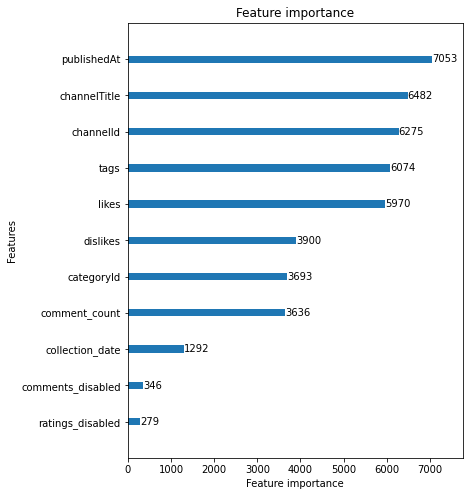

In [0]:
lgb.plot_importance(lgb_model,max_num_features=30, grid=False, figsize=(6,8))

In [0]:
pred_cv

array([inf, inf, inf, ..., inf, inf, inf])

In [0]:
pred_cv = np.expm1(pred_cv)
submit_df = pd.DataFrame({'y': pred_cv})
submit_df.index.name = 'id'
submit_df.index = submit_df.index + 1
submit_df.to_csv('F_submission_youtube.csv')

In [0]:
!nvidia-smi

Fri May  1 13:49:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# 新しいセクション